## 4.3 앙상블 학습 개요

1. 앙상블 학습 : 여러개의 분류기(Classifier)를 생성하고 그 **예측들을 결합함으로써 보다 정확한 예측을 도출**하는 기법
-> 넓은 의미로는 서로 다른 모델을 결합한 것들을 앙상블로 지칭하기도 한다.
<br><br>
2. 앙상블의 유형: **보팅, 배깅, 부스팅 그리고, 스태킹** 등의 기법이 존재
 1) 대표적인 유형

    대표적으로 배깅은 랜덤 포레스트,
    부스팅은 에이다 부스팅, 그래디언트 부스팅, XGBoost, LightGBM 등이 있다.
    * 데이터 분류나 회귀에서는 GBM부스팅 계열의 앙상블이 전반적으로 높은 예측 성능을 나타낸다.
* 뛰어난 성능을 가진 모델들로만 구성하는것 보다, 성능이 떨어지더라도 서로 다른 유형의 모델을 섞는것이 오히려 좋을 수 있다.
* 랜덤 포레스트 및 GBM 부스팅 알고리즘은 모두 결정 트리 알고리즘을 기반으로 한다.
* 결정 트리의 단점인 과적합을 수십~수천개의 많은 분류기를 결합해 보완. 장점인 직관적 분류 기준은 강화.

<img src="https://blog.kakaocdn.net/dn/r2AwS/btrBQDoQ8rw/sJQsQFV7RtiCam243xQwt0/img.png" width="1200">

### **보팅과 배깅의 차이점**

- **보팅**은 서로 다른 알고리즘을 가진 분류기를 결합하는 것이고,
- **배깅**(Bootstrap aggreagting):은 같은 유형의 알고리즘을 가진 분류기에 대해 데이터 샘플링을 서로 다르게 하는 것이다.

**참고**
- **부스팅**은 여러개의 약한 학습기(weak learner)를 순차적으로 학습-예측하면서 **잘못 예측한 데이터나 학습 트리에 가중치 부여를 통해 오류를 개선**해 나가면서 학습하는 방식.
- **스태킹**은 개별 알고리즘이 예측한 결과 -> 메타 데이터 세트 생성 -> 메타모델로 최종 학습 및 예측하는 방식.
    - 스태킹 예시)
```python
# 개별 ML 모델 객체 생성 (기반모델)
knn_clf = KNeighborsClassifier(n_neighbors=4)
rf_clf = RandomForestClassifier(n_estimators=100, random_state=30)
dt_clf = DecisionTreeClassifier()
ada_clf = AdaBoostClassifier(n_estimators=100)
# 메타모델(스태킹으로 만들어진 데이터 학습 및 예측)
lr_final = LogisticRegression(C=10)
```

### 하드보팅과 소프트보팅

<img src="https://blog.kakaocdn.net/dn/CKXdR/btrBT3TxdoA/WYKdgjidZlQ7DhEDwALTu0/img.png" width="1200">

* 하드 보팅: 다수의 분류기의 결과에 대해 민주주의
* 소프트 보팅: 다수의 분류기들의 결과 확률을 평균하여 결정

### Voting Classifier - 예시
- 위스콘신 유방암 데이터 로드

In [37]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [38]:
import pandas as pd

from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import warnings 
warnings.filterwarnings('ignore')

cancer = load_breast_cancer()

data_df = pd.DataFrame(cancer.data, columns=cancer.feature_names)
data_df.head(3)
data_df.shape, cancer.target.shape
cancer.target[:5]

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.0,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758


((569, 30), (569,))

array([0, 0, 0, 0, 0])

#### 로지스틱회귀와 KNN의 소프트보팅

In [2]:
# 개별 모델은 로지스틱 회귀와 KNN 임.
lr_clf = LogisticRegression(solver='liblinear')
knn_clf = KNeighborsClassifier(n_neighbors=8)

# 개별 모델을 소프트 보팅 기반의 앙상블 모델로 구현한 분류기
vo_clf = VotingClassifier( estimators=[ ('LR',lr_clf), ('KNN',knn_clf) ], voting='soft') # 소프트보팅 사용 (default는 하드보팅)
# data_df대신, cancer.data 써도 된다
X_train, X_test, y_train, y_test = train_test_split(data_df, cancer.target, 
                test_size=0.2, random_state=156)
# VotingClassifier 학습/예측/평가
vo_clf.fit(X_train, y_train)
pred = vo_clf.predict(X_test)
print(f"Voting 분류기의 정확도: {accuracy_score(y_test, pred):.2%}")

# 개별 모델의 학습/예측/평가
clsfs = [lr_clf, knn_clf]
for clsf in clsfs:
    clsf.fit(X_train,y_train)
    pred = clsf.predict(X_test)
    clsf_name = clsf.__class__.__name__
    print(f"{clsf_name}의 정확도: {accuracy_score(y_test,pred):.2%}")

Voting 분류기의 정확도: 95.61%
LogisticRegression의 정확도: 94.74%
KNeighborsClassifier의 정확도: 93.86%


## 4.4 배깅 - Random Forest

<img src="https://blog.kakaocdn.net/dn/UI4mz/btrBLUQUi85/4ZkFowKkm2rDabKMjkIrw0/img.png" width="1200">

### Random Forest의 하이퍼 파라미터

<img src="https://blog.kakaocdn.net/dn/ccsAkQ/btrBS0C9bny/wCEcsLRE7l5uKfBKmS88J1/img.png" width="1200">

- 기본적으로 n_estimators와 max_features, max_depth, min_samples_leaf만 튜닝해줘도 어느정도 성능 올릴 수 있다. 

#### Random Forest의 Bootstraping 분할

<img src="https://blog.kakaocdn.net/dn/HmGie/btrBR9t43hD/KJ6k1bNU4nY5UkCc6D9Sy0/img.png" width="1200">

- 랜덤포레스트 부트스트래핑 분할 : 일부가 중첩되게 서브샘플링으로 나누는 것 - 나머지가 검증 데이터로 쓰임

### Random Forest 이용한 human data

In [49]:
import pandas as pd
# 중복된 피처이름 처리
def get_new_feature_name_df(old_feature_name_df):
    feature_dup_df = pd.DataFrame(data=old_feature_name_df.groupby('column_name').cumcount(),
                                  columns=['dup_cnt'])
    feature_dup_df = feature_dup_df.reset_index()
    new_feature_name_df = pd.merge(old_feature_name_df.reset_index(), feature_dup_df, how='outer')
    new_feature_name_df['column_name'] = new_feature_name_df[['column_name', 'dup_cnt']].apply(lambda x : x[0]+'_'+str(x[1]) 
                                                                                         if x[1] >0 else x[0] ,  axis=1)
    new_feature_name_df = new_feature_name_df.drop(['index'], axis=1)
    return new_feature_name_df

#human 데이터셋 불러와서 피처중복 처리하고 Train, Test 데이터셋 나누기
def get_human_dataset( ):
    
    # 각 데이터 파일들은 공백으로 분리되어 있으므로 read_csv에서 공백 문자를 sep으로 할당.
    feature_name_df = pd.read_csv('./human_activity/features.txt',sep='\s+',
                        header=None,names=['column_index','column_name'])
    display(feature_name_df[feature_name_df.column_name.duplicated()].sort_values('column_name')[:5])
    # 중복된 피처명을 수정하는 get_new_feature_name_df()를 이용, 신규 피처명 DataFrame생성. 
    new_feature_name_df = get_new_feature_name_df(feature_name_df)
    
    # DataFrame에 피처명을 컬럼으로 부여하기 위해 리스트 객체로 다시 변환
    feature_name = new_feature_name_df.iloc[:, 1].values.tolist()
    
    # 학습 피처 데이터 셋과 테스트 피처 데이터을 DataFrame으로 로딩. 컬럼명은 feature_name 적용
    X_train = pd.read_csv('./human_activity/train/X_train.txt',sep='\s+', names=feature_name )
    X_test = pd.read_csv('./human_activity/test/X_test.txt',sep='\s+', names=feature_name)
    
    # 학습 레이블과 테스트 레이블 데이터을 DataFrame으로 로딩하고 컬럼명은 action으로 부여
    y_train = pd.read_csv('./human_activity/train/y_train.txt',sep='\s+',header=None,names=['action'])
    y_test = pd.read_csv('./human_activity/test/y_test.txt',sep='\s+',header=None,names=['action'])
    
    # 로드된 학습/테스트용 DataFrame을 모두 반환 
    return X_train, X_test, y_train, y_test

In [50]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# 결정 트리에서 사용한 get_human_dataset( )을 이용해 학습/테스트용 DataFrame 반환
X_train, X_test, y_train, y_test = get_human_dataset()

,column_index,column_name
338,339,"fBodyAcc-bandsEnergy()-1,16"
324,325,"fBodyAcc-bandsEnergy()-1,16"
328,329,"fBodyAcc-bandsEnergy()-1,24"
342,343,"fBodyAcc-bandsEnergy()-1,24"
316,317,"fBodyAcc-bandsEnergy()-1,8"


In [5]:
# 랜덤 포레스트 학습 및 별도의 테스트 셋으로 예측 성능 평가
rf_clf = RandomForestClassifier(n_estimators=100, random_state=0, max_depth=8)
rf_clf.fit(X_train, y_train)
pred = rf_clf.predict(X_test)
acc = accuracy_score(y_test,pred)
print(f"랜덤 포레스트 정확도: {acc:.2%}")

랜덤 포레스트 정확도: 91.96%


#### GridSearchCV를 통한 최적 하이퍼파라미터 찾기

In [6]:
from sklearn.model_selection import GridSearchCV
params = {
    'n_estimators' : [100, 110, 120],
    'max_depth' : [8, 16],
    'min_samples_leaf' : [1, 6], # leaf가 되기위해 필요한 최소한 샘플 개수
    'min_samples_split' : [2, 8]
}

# RandomForestClassifier 객체 생성 후 GridSearchCV 수행
rf_clf = RandomForestClassifier(n_estimators=100, random_state=0, n_jobs=-1)
grid_cv = GridSearchCV(rf_clf, param_grid=params, cv=2, n_jobs=-1)
grid_cv.fit(X_train, y_train)

print(f"최적 하이퍼 파라미터:\n{grid_cv.best_params_}")
print(f"최고 예측 정확도: {grid_cv.best_score_:.2%}")

최적 하이퍼 파라미터:
{'max_depth': 16, 'min_samples_leaf': 6, 'min_samples_split': 2, 'n_estimators': 100}
최고 예측 정확도: 91.65%


In [7]:
# n_estimators 100개 일때
best_rf_clf = grid_cv.best_estimator_
pred = best_rf_clf.predict(X_test)
print(best_rf_clf)
print(f"예측 정확도 : {accuracy_score(y_test, pred):.2%}")

RandomForestClassifier(max_depth=16, min_samples_leaf=6, n_jobs=-1,
                       random_state=0)
예측 정확도 : 92.60%


#### Feature Importance 그리기

In [8]:
# featrue importance 높은 것부터 5개 보기
ftr_import = pd.Series(best_rf_clf.feature_importances_, index=X_train.columns)
ftr_import.sort_values(ascending=False)[:5]

angle(X,gravityMean)    0.035312
tGravityAcc-mean()-Y    0.033729
tGravityAcc-min()-X     0.030276
angle(Y,gravityMean)    0.029013
tGravityAcc-max()-X     0.027538
dtype: float64

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("dark_background")
%matplotlib inline

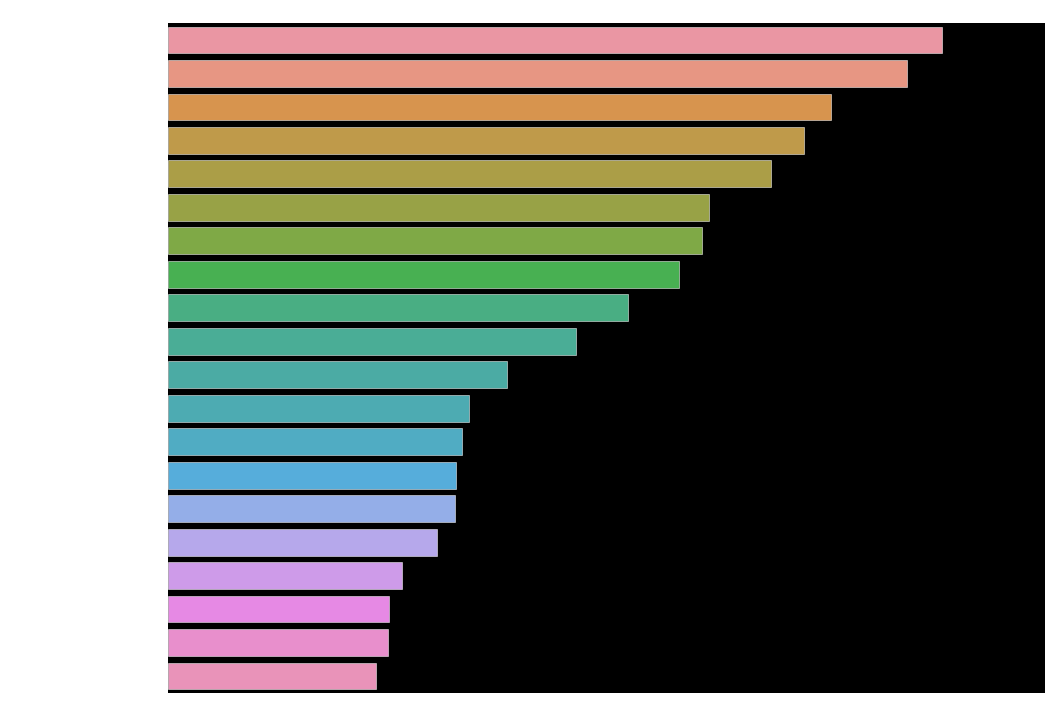

In [28]:
# Feature importances 상위 20개
ftr_tp20 = ftr_import.sort_values(ascending=False)[:20]

plt.figure(figsize=(14,12))
plt.title("Feature Importances Top 20")
sns.barplot(x=ftr_tp20.values, y=ftr_tp20.index)
plt.show()

## 부스팅
- 부스팅 알고리즘은 여러개의 약한 학습기(weak learner)를 순차적으로 학습-예측하면서 잘못 예측한 데이터나 학습 트리에 가중치 부여를 통해 오류를 개선해 나가면서 학습하는 방식.
- 부스팅의 대표적인 구현은 AdaBoost(Adaptive boosting)와 그래디언트 부스트가 있습니다.

### 에이다 부스팅의 학습/예측 프로세스
- 분류하고, 남은 애들에게 가중치 주고 또 분류하고 반복

<img src="https://blog.kakaocdn.net/dn/ck4ZeB/btrB67v2SCF/NLMbiFW1Bqy7sWj9ZmaE6K/img.png" width=1200>

### 4.5 GBM(Gradient Boosting Machine)
- GBM은 에이다부스트와 유사하지만, **가중치 업데이트를 경사 하강법(Gradient Descent)를 이용한 것이 큰 차이**

<img src="https://blog.kakaocdn.net/dn/u8g1q/btrCbopQi8G/nqrKSTemdNkXdHo1K9Z9Ak/img.png" width=1200>

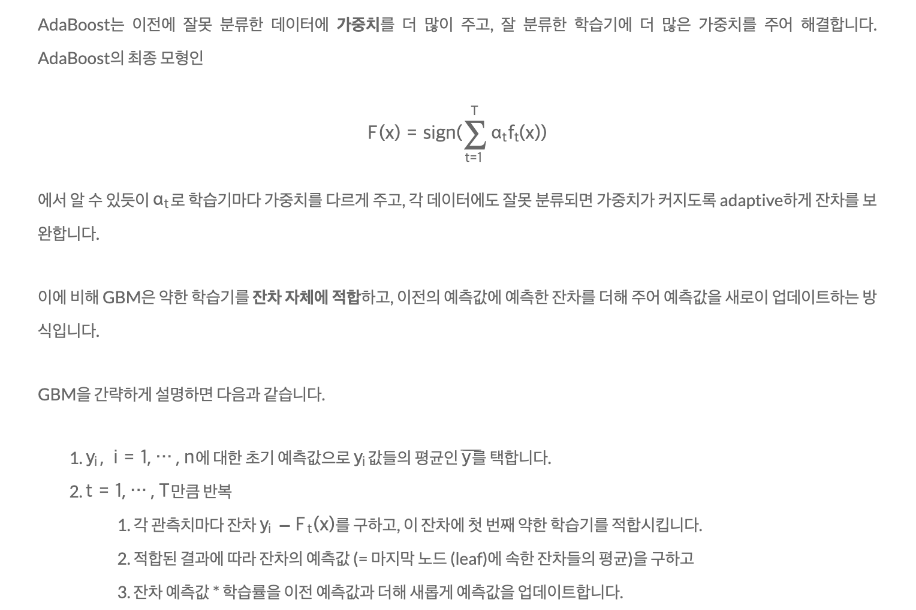
참조: https://assaeunji.github.io/machine%20learning/2020-09-05-gbm/

#### GBM 주요 하이퍼 파라미터

<img src=https://blog.kakaocdn.net/dn/bSp60O/btrCcEFYr1V/TfeLSFKIxRQI0KPssZamak/img.png width=1200>

In [48]:
from sklearn.ensemble import GradientBoostingClassifier
import time
import warnings
warnings.filterwarnings('ignore')

X_train, X_test, y_train, y_test = get_human_dataset()

# GBM 수행시간 측정을 위함. 시작 시간 설정.
start = time.time()

gb_clf = GradientBoostingClassifier(random_state=0)
gb_clf.fit(X_train, y_train)
gb_pred = gb_clf.predict(X_test)
acc = accuracy_score(y_test, gb_pred)

print(f"GBM 정확도: {acc:.2%}")
print(f"GBM 수행 시간: {time.time() - start:.1f}초")

GBM 정확도: 0.9386
GBM 수행 시간: 469.0 초 


In [69]:
### 아래는 GridSearchCV로 GBM의 하이퍼 파라미터 튜닝 수행 예제
## 사이킷런 1.X 업데이트되면서 속도가 매우 오래걸림, 아래 예제는 약 1시간 20분정도 걸림

from sklearn.model_selection import GridSearchCV

params = {
    'n_estimators': [100,500],
    'learning_rate': [0.05, 0.1]
}
gb_clf = GradientBoostingClassifier(random_state=0)
g_cv = GridSearchCV(gb_clf, param_grid=params, cv=2, verbose=1)
g_cv.fit(X_train, y_train)
print(f"최적 하이퍼 파라미터:\n{g_cv.best_params_}")
print(f"학습데이터 최고 예측 정확도: {g_cv.best_score_}")
gb_pred = g_cv.best_estimator_.predict(X_test)
gb_acc = accuracy_score(y_test, gb_pred)
print(f"GBM 정확도: {gb_acc:.2%}")

Fitting 2 folds for each of 4 candidates, totalling 8 fits
최적 하이퍼 파라미터:
{'learning_rate': 0.05, 'n_estimators': 500}
학습데이터 최고 예측 정확도: 0.9001632208922742
GBM 정확도: 93.96%
